In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
MODEL
"""
# Use a Ladder CNN in addition to the image encoder?
use_cnn = False
# Run the resizing operations after the CNN? (might preserve fine pixel-level details better)
resize_before_cnn = True

# Use LoRA on the mask decoder? (if False, trains the whole decoder)
mask_ft = False
mask_lora = True
mask_r = 8

# use LoRa on the image encoder transformer?
vit_lora = False
vit_r = 8

# train the image encoder's patch embedding CNN? Highly recommended.
vit_patch_embed = True

use_cls_tokens = True
model_size = "vit_h"

"""
TRAINING
"""
run_grad = True

focal_scale = 20
mse_scale = 1
dice_scale = 1
ce_scale = 1
cls_scale = 1

only_cls_loss = True

num_refinement_steps = 0

cache_embeddings = True
warm_start = True

"""
DATA
"""
create_valid = True
cls_ids = None # any
train_size = None # images

valid_size = 20 # images
valid_prompts = 500

use_masks = True
grow_masks = False
growth_radius = 15

# train on semantic segmentation or point/box-to-mask?
tasks = ["point","box"]

points_per_mask = 1
points_per_side = 20
points_per_img = 50

In [3]:
import sys
import os
# sys.path.append(os.path.relpath("./segment-anything"))
# inserting to front instead:
sys.path.insert(0, os.path.relpath("./segment-anything"))
import segment_anything

%cd datasets/
from fine_tune.configs.climbing import *
%cd ..

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 4015.04it/s]

/home/andrewhealey/sam-fine-tuning


In [4]:
import supervision as sv
from fine_tune.datasets import extract_classes_from_dataset,shrink_dataset_to_size

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=use_masks
)

if create_valid:
    # split the training set into train/valid
    train_dataset,valid_dataset = train_dataset.split(0.8)

if train_size is not None:
    train_dataset = shrink_dataset_to_size(train_dataset,train_size)

if cls_ids is not None:
    print("Selecting classes",[train_dataset.classes[i] for i in cls_ids])
    train_dataset = extract_classes_from_dataset(train_dataset,cls_ids)

if not create_valid:
    valid_dataset = sv.DetectionDataset.from_coco(
        images_directory_path=f"{dataset.location}/valid",
        annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
        force_masks=use_masks
    )

if valid_size is not None:
    valid_dataset = shrink_dataset_to_size(valid_dataset,valid_size)

if cls_ids is not None:
    valid_dataset = extract_classes_from_dataset(valid_dataset,cls_ids)

Selecting classes ['climbing-holds', 'floor', 'person']


In [5]:
num_classes = len(train_dataset.classes)
num_classes

3

In [6]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [7]:
valid_names = set(k.split(".rf")[0] for k in valid_dataset.images.keys())
train_names = set(k.split(".rf")[0] for k in train_dataset.images.keys())

# Check that there's no training/valid pollution
assert len(valid_names.intersection(train_names)) == 0,"There is overlap between the training and validation sets."

In [8]:
from persam.load import load_predictor
from fine_tune.samed import LoRA_Mask_Decoder,LoRA_Tiny_Image_Encoder
from fine_tune.ladder_cnn import CNN_SAM

predictor = load_predictor(model_size,num_classes=num_classes)

if mask_lora:
    lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=mask_r)
    mask_decoder = lora_mask_decoder.mask_decoder.cuda()
else:
    mask_decoder = predictor.model.mask_decoder

if use_cls_tokens:
    mask_decoder.add_cls_token(num_classes=num_classes)

if use_cls_tokens and warm_start:
    # warm-start the cls tokens to match the single-mask token
    mask_decoder.cls_mask_tokens.weight.data = mask_decoder.mask_tokens.weight.data[0].unsqueeze(0).repeat(num_classes,1)
    # ditto for hypernetwork MLPs
    main_hypernetwork_mlp = mask_decoder.output_hypernetworks_mlps[0]
    for cls_hypernetwork_mlp in mask_decoder.cls_hypernetworks_mlps:
        # deep copy state dict of main hypernetwork MLP
        cls_hypernetwork_mlp.load_state_dict(main_hypernetwork_mlp.state_dict().copy())

if vit_lora:
    lora_image_encoder = LoRA_Tiny_Image_Encoder(predictor.model.image_encoder,r=vit_r).cuda()
    image_encoder = lora_image_encoder.image_encoder
else:
    image_encoder = predictor.model.image_encoder

if use_cnn:
    cnn_sam = CNN_SAM(resize_before_cnn=resize_before_cnn).to("cuda")
else:
    cnn_sam = None

Init MaskDecoder True


In [9]:
import torch

cfg_num = None

"""
Export code:

torch.save(mask_decoder.state_dict(), f'mask_decoder_{run_num}.pt')
if use_cnn:
    torch.save(cnn_sam.state_dict(), f'ladder_{run_num}.pt')
if mask_lora:
    lora_mask_decoder.save_lora_parameters(f"mask_lora_{run_num}.pt")
if vit_lora:
    lora_image_encoder.save_lora_parameters(f"vit_lora_{run_num}.pt")
if use_cls_tokens:
    # select state dict with properties num_classes, cls_iou_token, cls_mask_tokens, cls_hypernetworks_mlps, cls_iou_prediction_head
    # decoder_state_dict = {k:v for k,v in mask_decoder.state_dict().items() if k.startswith("cls")}
    torch.save(mask_decoder.state_dict(), f"cls_decoder_{run_num}.pt")
if vit_patch_embed:
    torch.save(image_encoder.patch_embed.state_dict(), f"vit_patch_embed_{run_num}.pt")
"""


# load exported weights
if cfg_num is not None:
    %cd runs/
    mask_decoder.load_state_dict(torch.load(f"mask_decoder_{cfg_num}.pt"))
    if use_cnn:
        cnn_sam.load_state_dict(torch.load(f"ladder_{cfg_num}.pt"))
    if mask_lora:
        lora_mask_decoder.load_lora_parameters(f"mask_lora_{cfg_num}.pt")
    if vit_lora:
        lora_image_encoder.load_lora_parameters(f"vit_lora_{cfg_num}.pt")
    if use_cls_tokens:
        mask_decoder.cls_mask_tokens.weight.data = mask_decoder.mask_tokens.weight.data[0].unsqueeze(0).repeat(num_classes,1)
        # ditto for hypernetwork MLPs
        main_hypernetwork_mlp = mask_decoder.output_hypernetworks_mlps[0]
        for cls_hypernetwork_mlp in mask_decoder.cls_hypernetworks_mlps:
            # deep copy state dict of main hypernetwork MLP
            cls_hypernetwork_mlp.load_state_dict(main_hypernetwork_mlp.state_dict().copy())
        # torch.save(mask_decoder.state_dict(), f"cls_decoder_{run_num}.pt")
    if vit_patch_embed:
        image_encoder.patch_embed.load_state_dict(torch.load(f"vit_patch_embed_{cfg_num}.pt"))
    %cd ..

In [10]:
from fine_tune.common import grow_dataset_masks

if grow_masks:
    grow_dataset_masks(train_dataset,growth_radius=growth_radius)
    grow_dataset_masks(valid_dataset,growth_radius=growth_radius)

In [11]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, SamEverythingDataset, RandomPointDataset, SamDummyMaskDataset, SamSemSegDataset, SamComboDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

cache_dir = "./cache"

from torch.utils.data import ConcatDataset

args = [predictor,device,cache_embeddings,cache_dir]
dataset_makers = {
    "sem_seg": lambda ds: SamSemSegDataset(ds,*args),
    "box": lambda ds: SamBoxDataset(ds,*args),
    "point": lambda ds: SamPointDataset(ds,*args,points_per_mask=points_per_mask),
    "cls": lambda ds: SamMidasBinaryClassification(ds,*args),
    "dummy": lambda ds: SamDummyMaskDataset(ds,*args),
    "everything": lambda ds: SamEverythingDataset(ds,*args,points_per_side=points_per_side,top_k=None),
    "random": lambda ds: RandomPointDataset(ds,*args,points_per_img=points_per_img),
}

def prep_datasets(ds):
    datasets = []
    for task in tasks:
        datasets.append(dataset_makers[task](ds))
    return SamComboDataset(datasets,*args)

curr_dataset = prep_datasets(train_dataset)
valid_curr_dataset = prep_datasets(valid_dataset)

from torch.utils.data import random_split
if valid_prompts is not None:
    num_prompts = len(valid_curr_dataset)

    # split off prompts
    valid_curr_dataset,_ = random_split(valid_curr_dataset,[valid_prompts,num_prompts-valid_prompts])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 105611.97it/s]


In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Hyperparameters
initial_lr = 2e-4
weight_decay = 0.1


warmup_steps = 500
total_steps = 150_000
batch_size = 5 # perform gradient accumulation for this--they do 256 images per batch.
log_period = 200 # a few batches
eval_period = 500
wandb_log_period = 20

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

if use_cls_tokens:
    mask_decoder = mask_decoder.cuda()
    for param in mask_decoder.parameters():
        param.requires_grad = False
    for param_set in [mask_decoder.cls_mask_tokens,mask_decoder.cls_iou_token,mask_decoder.cls_hypernetworks_mlps,mask_decoder.cls_iou_prediction_head]:
        for param in param_set.parameters():
            param.requires_grad = True

combined_params = list(predictor.model.mask_decoder.parameters())
if use_cnn:
    combined_params += list(cnn_sam.parameters())
if vit_patch_embed: combined_params += list(image_encoder.patch_embed.parameters())
optimizer = optim.AdamW(combined_params, lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

num_params = sum([np.prod(p.size()) for p in combined_params if p.requires_grad])
print(f"Total trainable parameters: {num_params}")

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

Total trainable parameters: 552803


In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
from numpy.random import permutation
from tqdm import tqdm
import json

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt
from fine_tune.prompts import make_refinement_prompt


In [14]:
from PIL import Image
import numpy as np
from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

mse = nn.MSELoss()

# cross entropy loss with logits
ce = nn.CrossEntropyLoss()

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0
    for decoder_input, gt_masks, (gt_cls,gt_cls_logits), (input_size,original_size), img, (unresized_img,resized_img),mask_loss in tqdm(valid_curr_dataset):

        use_cls_loss = gt_cls is not None and use_cls_tokens

        with torch.no_grad():
            new_input = {**decoder_input}
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
                curr_embedding = decoder_input["image_embeddings"]
                new_input["image_embeddings"] = curr_embedding + cnn_embedding

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).squeeze(0).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[:,:,:]

            max_idx = torch.argmax(iou_predictions)
            pred_mask = upscaled_masks[max_idx]
            binary_mask = binary_masks[max_idx]

            gt_binary_mask, _, max_iou, *_ = get_max_iou_masks(gt_masks,binary_mask[None,...])

            flat_pred_mask = pred_mask.view(1,-1) # as logits
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            if use_cls_loss:

                cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
                cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

                max_cls = torch.argmax(cls_iou_predictions)
                cls_binary_mask = cls_binary_masks[max_cls]
                cls_pred_mask = cls_upscaled_masks[None,max_cls,:,:]

                assert len(cls_iou_predictions.shape)==2,f"cls_predictions has shape {cls_iou_predictions.shape}"
                cls_pred_iou = F.sigmoid(cls_iou_predictions[0,max_cls])

                # get focal and dice loss between cls_binary_mask and closest gt mask
                cls_gt_binary_mask,cls_binary_mask,cls_max_iou,_,best_det = get_max_iou_masks(gt_masks,cls_binary_mask[None,...],gt_cls,max_cls[None,...])

                flat_cls_pred_mask = cls_pred_mask.view(1,-1)
                flat_gt_cls_binary_mask = cls_gt_binary_mask.view(1,-1)

                # simultaneously treat cls iou predictions as probabilities and IoU logits.
                # I think this is OK because cross-entropy loss is bias-independent.
                cls_ce_loss = F.cross_entropy(cls_iou_predictions[0],gt_cls_logits[best_det])
                cls_mse_loss = mse(cls_pred_iou,cls_max_iou)

                cls_loss = ce_scale * cls_ce_loss + mse_scale * cls_mse_loss
                if mask_loss:
                    cls_focal_loss = calculate_sigmoid_focal_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask,should_sigmoid=True)
                    cls_dice_loss = calculate_dice_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask, should_sigmoid=True)

                    cls_loss += dice_scale * cls_dice_loss + focal_scale * cls_focal_loss
                    
            else:
                cls_loss = torch.tensor(0,dtype=torch.float32,device=device)
            

            # if use_cls_loss AND only_cls_loss, then only train the cls loss
            # if use_cls_loss AND NOT only_cls_loss, then train both cls and mask loss
            # if NOT use_cls_loss, then train only mask loss
            if only_cls_loss and use_cls_loss:
                loss = torch.tensor(0,dtype=torch.float32,device=device)

            else:
                focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
                dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask, should_sigmoid=True)

                loss = dice_scale * dice_loss + focal_scale * focal_loss

            if use_cls_loss:
                loss += cls_loss

            running_loss += loss.item()
            running_count += 1
    valid_loss = running_loss/running_count

    wandb.log({
        "valid_loss": valid_loss,
    })

    print(f"VALID - Loss: {valid_loss:.4f}")

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [32]:
run_grad = False
curr_dataset = valid_curr_dataset

In [35]:
run = wandb.init(
    project="sam-fine-tune",
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

use_postprocess = True

curr_epoch = 0

# iter through dataset in random order
while curr_iters < total_steps:
    evaluate()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            decoder_input, gt_masks, (gt_cls,gt_cls_logits), sizing, img, (unresized_img,resized_img),mask_loss = curr_dataset[idx]
        
        use_cls_loss = gt_cls is not None and use_cls_tokens
        
        input_size,original_size = sizing
        new_input = {**decoder_input}

        has_fresh_prompt = True
        refinements_remaining = num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            _,H,W = gt_masks.shape

            if vit_lora:
                sam_embedding = image_encoder(resized_img)[0]
                new_input["image_embeddings"] = sam_embedding
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img, resized_img).squeeze(0)

                curr_embedding = new_input["image_embeddings"]

                new_input["image_embeddings"] = curr_embedding + cnn_embedding
            
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

            high_res_masks = F.interpolate(
                    low_res_masks,
                    (H, W),
                    mode="bilinear",
                    align_corners=False,
                )
            high_res_masks = high_res_masks.squeeze(0)
            assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).squeeze(0).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[:,:,:]

            gt_binary_mask, binary_mask, iou, pred_idx, _ = get_max_iou_masks(gt_masks,binary_masks)
            pred_iou = iou_predictions[0,pred_idx]

            pred_mask = upscaled_masks[pred_idx] if use_postprocess else high_res_masks[pred_idx]

            assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
            h,w = gt_binary_mask.shape

            flat_pred_mask = pred_mask.view(1,-1)
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            focal_loss = torch.tensor(0,device=device,dtype=torch.float32)
            dice_loss = torch.tensor(0,device=device,dtype=torch.float32)
            mse_loss = torch.tensor(0,device=device,dtype=torch.float32)
            loss = torch.tensor(0,device=device,dtype=torch.float32)

            cls_focal_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_dice_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_ce_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_mse_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_loss = torch.tensor(0,device=device,dtype=torch.float32)

            if use_cls_loss:

                cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
                cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

                # get focal and dice loss between cls_binary_mask and closest gt mask
                cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls,best_det = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

                cls_pred_mask = cls_upscaled_masks[best_cls,:,:]
                cls_pred_iou = F.sigmoid(cls_iou_predictions[0,best_cls])

                flat_cls_pred_mask = cls_pred_mask.view(1,-1)
                flat_gt_cls_binary_mask = cls_gt_binary_mask.view(1,-1)

                cls_focal_loss = calculate_sigmoid_focal_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask,should_sigmoid=True)
                cls_dice_loss = calculate_dice_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask, should_sigmoid=True)

                cls_ce_loss = F.cross_entropy(cls_iou_predictions[0],gt_cls_logits[best_det])
                cls_mse_loss = mse(cls_pred_iou,max_iou)

                cls_loss += ce_scale * cls_ce_loss + mse_scale * cls_mse_loss

                if mask_loss:
                    cls_loss += dice_scale * cls_dice_loss + focal_scale * cls_focal_loss
                
                loss += cls_loss
                
            if not (use_cls_loss and only_cls_loss):
                focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
                dice_loss = calculate_dice_loss(flat_gt_binary_mask, flat_gt_binary_mask, should_sigmoid=True)
                mse_loss = mse(pred_iou, iou)

                loss += mse_scale * mse_loss
                if mask_loss:
                    loss += dice_scale * dice_loss + focal_scale * focal_loss
                
            #
            # WandB
            #
            
            loss_dict = {
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
                "cls_loss": cls_loss.cpu().item(),
                "cls_focal_loss": cls_focal_loss.cpu().item(),
                "cls_dice_loss": cls_dice_loss.cpu().item(),
                "cls_mse_loss": cls_mse_loss.cpu().item(),
                "cls_ce_loss": cls_ce_loss.cpu().item(),
            }

            # remove 0-valued losses -- assume they're not used
            loss_dict = {k:v for k,v in loss_dict.items() if v != 0}

            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-log_period:]

            if curr_iters % eval_period == 0:
                pass

            if curr_iters % log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1
            if not run_grad: continue
            accumulated_loss += loss
            if curr_iters % batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            warmup_scheduler.step(curr_iters)
            lr_decay_scheduler.step(curr_iters)

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:
                new_prompt = make_refinement_prompt(pred_mask, gt_binary_mask)
                new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

                # extract image_embeddings and context_embeddings from old decoder_input
                new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
                }

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


cls_ce_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
cls_dice_loss,█▂▅▁▂▂▂▂▁▁▂▂▁▂▁▂▃▁▁▂▁▂▂▂▂▂▁▁▂▂▁▁▆▆▃▁▂▁▁▂
cls_focal_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cls_loss,▇▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁
cls_mse_loss,▄▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁█▂▁▁▂▁▁
loss,▇▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁
valid_loss,▁▁▁▁▁
cls_ce_loss,0.00045
cls_dice_loss,0.13662
cls_focal_loss,0.00062
cls_loss,0.14943


100%|██████████| 200/200 [00:04<00:00, 44.62it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:04, 39.78it/s]

Loss: 1.052193522453308


100%|██████████| 200/200 [00:04<00:00, 45.32it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 40.47it/s]

Loss: 0.7498952624201775


100%|██████████| 200/200 [00:04<00:00, 47.98it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 41.88it/s]

Loss: 0.7465797474980355


100%|██████████| 200/200 [00:04<00:00, 47.02it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 40.87it/s]

Loss: 0.7491112150251865


100%|██████████| 200/200 [00:04<00:00, 46.92it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:04, 39.37it/s]

Loss: 0.7547307263314724


100%|██████████| 200/200 [00:04<00:00, 46.89it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 42.02it/s]

Loss: 0.7455133976042271


100%|██████████| 200/200 [00:04<00:00, 46.62it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 38.18it/s]

Loss: 0.7717069147527218


100%|██████████| 200/200 [00:04<00:00, 42.55it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 38.50it/s]

Loss: 0.731472829580307


100%|██████████| 200/200 [00:04<00:00, 43.59it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 40.49it/s]

Loss: 0.751082044839859


100%|██████████| 200/200 [00:04<00:00, 46.64it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 39.13it/s]

Loss: 0.7468336449563503


100%|██████████| 200/200 [00:04<00:00, 47.16it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 39.11it/s]

Loss: 0.7501195014268159


100%|██████████| 200/200 [00:04<00:00, 46.41it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 41.31it/s]

Loss: 0.7512659316509962


100%|██████████| 200/200 [00:04<00:00, 46.42it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 39.43it/s]

Loss: 0.7534022141993045


100%|██████████| 200/200 [00:04<00:00, 46.16it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:04, 39.97it/s]

Loss: 0.745581536218524


100%|██████████| 200/200 [00:04<00:00, 45.63it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 40.48it/s]

Loss: 0.7501674580574036


100%|██████████| 200/200 [00:04<00:00, 46.86it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 37.69it/s]

Loss: 0.7499856245145202


100%|██████████| 200/200 [00:04<00:00, 47.53it/s]


VALID - Loss: 0.9374


  2%|▏         | 3/200 [00:00<00:06, 29.44it/s]

Loss: 0.7729725934192538


100%|██████████| 200/200 [00:04<00:00, 46.75it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:04, 39.98it/s]

Loss: 0.7270598360151053


100%|██████████| 200/200 [00:04<00:00, 44.69it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Loss: 0.7501405629515648


100%|██████████| 200/200 [00:04<00:00, 47.68it/s]


VALID - Loss: 0.9374


  2%|▎         | 5/200 [00:00<00:04, 42.15it/s]

Loss: 0.750494806393981


100%|██████████| 200/200 [00:04<00:00, 42.18it/s]


VALID - Loss: 0.9374


  2%|▏         | 4/200 [00:00<00:05, 38.55it/s]

Loss: 0.7501215332746506


 61%|██████    | 122/200 [00:03<00:01, 39.26it/s]


KeyboardInterrupt: 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3634.64it/s]


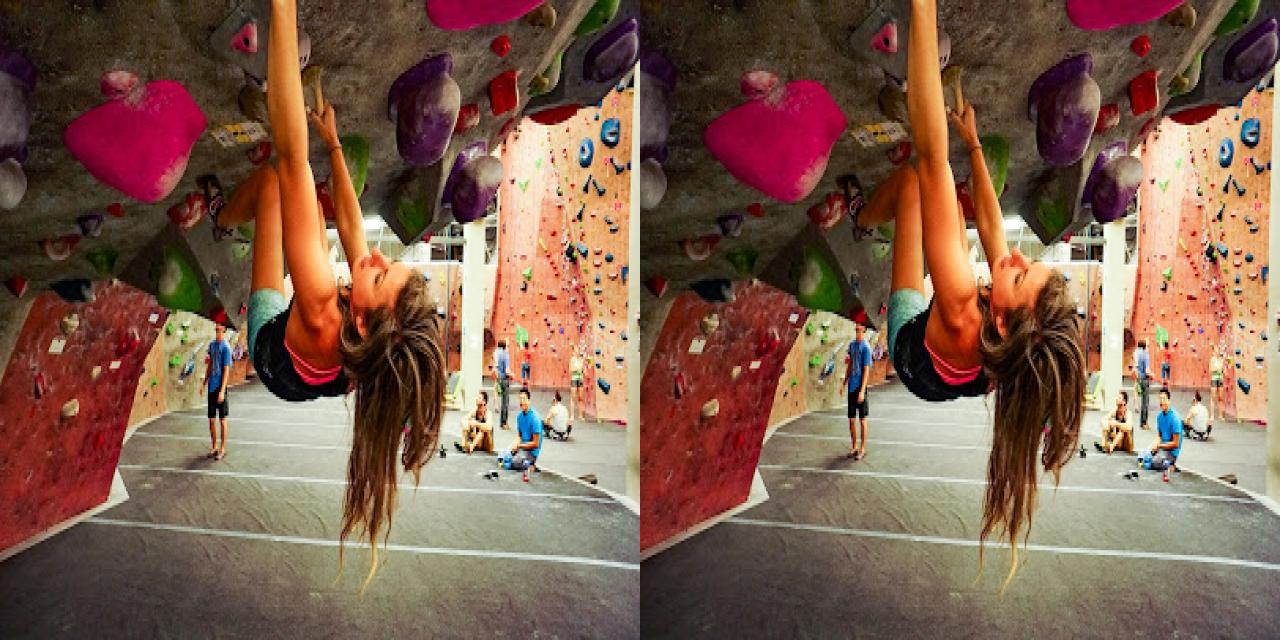

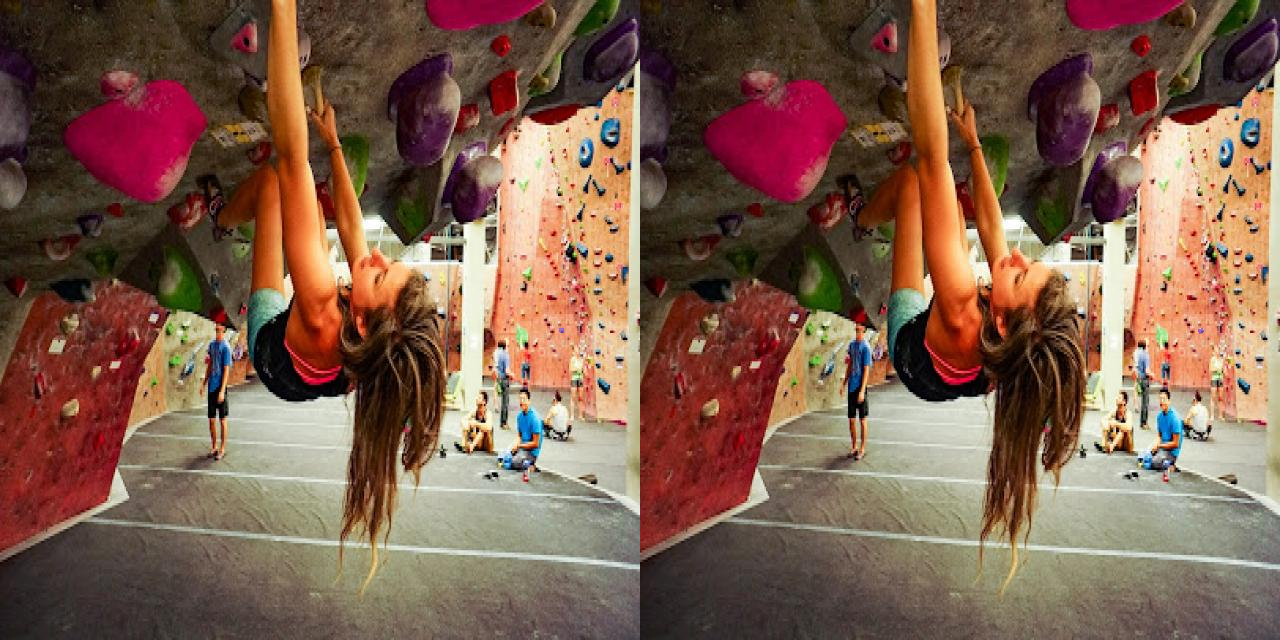

In [ ]:
clip_together_imgs(mask_to_img(cls_pred_mask > 0,img),mask_to_img(gt_binary_mask,img)).show()
clip_together_imgs(mask_to_img(pred_mask > 0,img),mask_to_img(gt_binary_mask,img)).show()

In [ ]:
from glob import glob
%cd runs/

run_cfgs = glob('cfg_*.json')
highest_run = max([int(cfg.split('_')[1].split('.')[0]) for cfg in run_cfgs])
run_num = highest_run + 1
print(f"Run number: {run_num}")

dataset_path = dataset.location
import os
dataset_name = os.path.basename(dataset_path)

cfg = {
    "dataset_name": dataset_name,
    "use_cnn": use_cnn,
    "resize_before_cnn": resize_before_cnn,
    "grow_masks": grow_masks,
    "mask_lora": mask_lora,
    "mask_r": mask_r,
    "vit_lora": vit_lora,
    "vit_r": vit_r,
    "vit_patch_embed": vit_patch_embed,
    "initial_lr": initial_lr,
    "weight_decay": weight_decay,
    "warmup_steps": warmup_steps,
    "total_steps": total_steps,
    "batch_size": batch_size,
    "lr_decay_steps": lr_decay_steps,
    "lr_decay_factor": lr_decay_factor,
    "run_name":run.name,
    "run_url":run.url,
    "run_grad": run_grad,
    "use_masks": use_masks,
    "dice_scale": dice_scale,
    "focal_scale": focal_scale,
    "ce_scale": ce_scale,
    "num_classes": num_classes,
    "tasks": tasks,
    "create_valid": create_valid,
    "num_refinement_steps": num_refinement_steps,
}

with open(f'cfg_{run_num}.json', 'w') as f:
    json.dump(cfg, f, indent=4)

torch.save(mask_decoder.state_dict(), f'mask_decoder_{run_num}.pt')
if use_cnn:
    torch.save(cnn_sam.state_dict(), f'ladder_{run_num}.pt')
if mask_lora:
    lora_mask_decoder.save_lora_parameters(f"mask_lora_{run_num}.pt")
if vit_lora:
    lora_image_encoder.save_lora_parameters(f"vit_lora_{run_num}.pt")
if use_cls_tokens:
    # select state dict with properties num_classes, cls_iou_token, cls_mask_tokens, cls_hypernetworks_mlps, cls_iou_prediction_head
    # decoder_state_dict = {k:v for k,v in mask_decoder.state_dict().items() if k.startswith("cls")}
    torch.save(mask_decoder.state_dict(), f"cls_decoder_{run_num}.pt")
if vit_patch_embed:
    torch.save(image_encoder.patch_embed.state_dict(), f"vit_patch_embed_{run_num}.pt")
# if num_classes > 0:
#     torch.save(mask_decoder.class_tokens.state_dict(), f"class_tokens_{run_num}.pt")
#     torch.save(mask_decoder.class_prediction_head.state_dict(), f"class_prediction_head_{run_num}.pt")

%cd ..

/home/andrewhealey/sam-fine-tuning/runs
Run number: 76
/home/andrewhealey/sam-fine-tuning


In [16]:
evaluate()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:04<00:00, 46.20it/s]

VALID - Loss: 0.9374


In [ ]:
from fine_tune.datasets import load_dir_as_dataset

test_dataset = load_dir_as_dataset("datasets/own-plate-test")

test_curr_dataset = prep_datasets(test_dataset)


100%|██████████| 7/7 [00:00<00:00, 42003.04it/s]


In [ ]:
idx = -1

0 climbing-holds


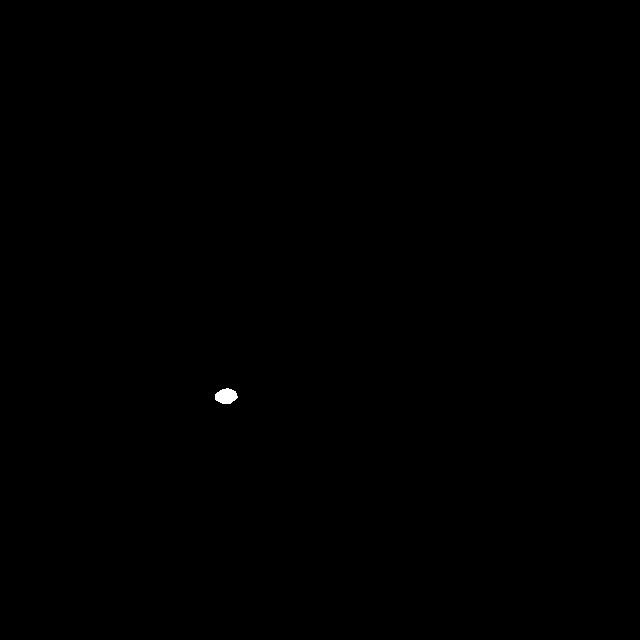

In [ ]:
from fine_tune.viz import render_prompt,mask_to_img

img,prompt = valid_curr_dataset.prompts[10]
print(prompt.gt_cls,valid_dataset.classes[prompt.gt_cls])
Image.fromarray(prompt.gt_mask).show()
# render_prompt(img,prompt,valid_dataset)# 

one mask
tensor([0], device='cuda:0') tensor(0, device='cuda:0')
Predicted IoU: 0.7886220216751099
Predicted class: climbing-holds


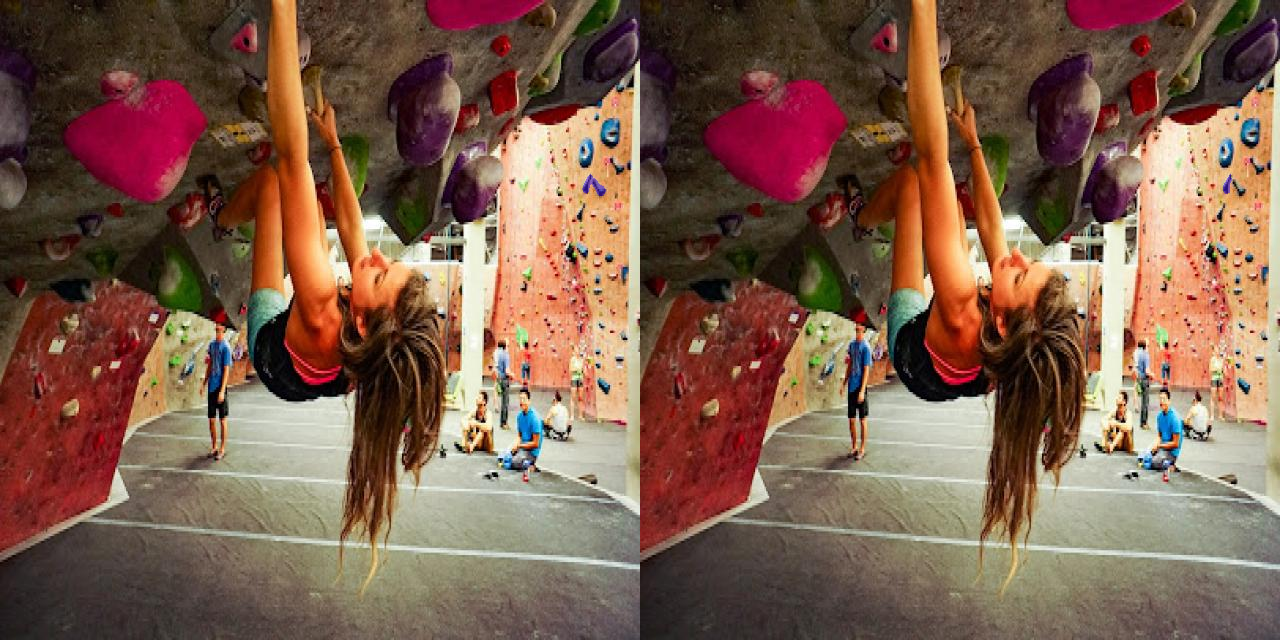

cls binary masks:


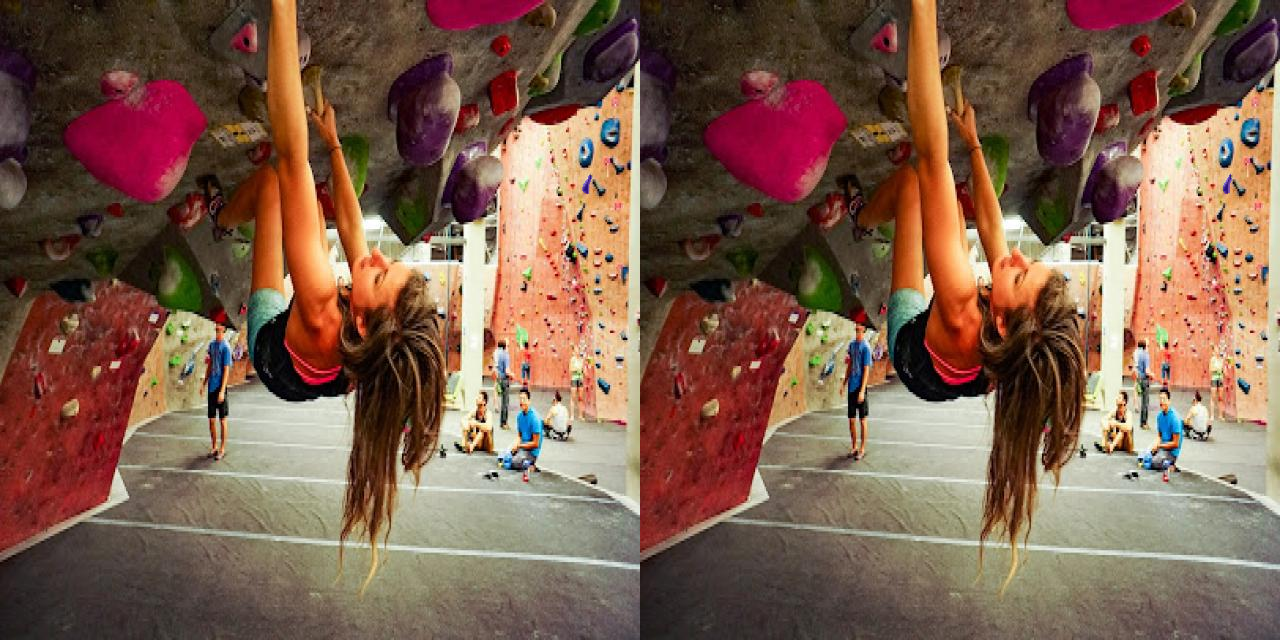

In [30]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

decoder_input, gt_masks, (gt_cls,gt_cls_logits), sizing, img, (unresized_img,resized_img),mask_loss = v_c_ds[idx]
input_size,original_size = sizing
has_fresh_prompt = True
num_refinements_left = num_refinement_steps
new_input = {**decoder_input}
while has_fresh_prompt:
    has_fresh_prompt = False

    print("one mask" if len(gt_masks) == 1 else "multiple masks")

    with torch.no_grad():
        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
            curr_embedding = decoder_input["image_embeddings"]
            new_input["image_embeddings"] = curr_embedding + cnn_embedding
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

    # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
    upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
    binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

    max_idx = torch.argmax(iou_predictions).item()
    iou = iou_predictions[0,max_idx].item()

    gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)
    binary_mask = binary_masks[max_idx]

    if gt_cls is not None and use_cls_tokens:

        cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
        cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

        # get focal and dice loss between cls_binary_mask and closest gt mask
        cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls,best_det = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

        cls_pred_mask = cls_upscaled_masks[best_cls,:,:]
        
        print(gt_cls,best_cls)

    if num_refinements_left > 0:
        has_fresh_prompt = True
        num_refinements_left -= 1

        new_prompt = make_refinement_prompt(binary_mask, gt_binary_mask)
        new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

        # extract image_embeddings and context_embeddings from old decoder_input
        new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
        }



from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

if False:
    with torch.no_grad():

        flat_binary_mask = binary_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
        dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
        iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
        loss = focal_loss + dice_loss
        print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

print("Predicted IoU:",iou)
print("Predicted class:",valid_dataset.classes[best_cls])
# print("Predicted class:",torch.argmax(pred_logits).item(),"GT class:",torch.argmax(gt_cls_logits[0]).item())

clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()
# clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

print("cls binary masks:")
clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

torch.Size([1, 1, 640, 640])


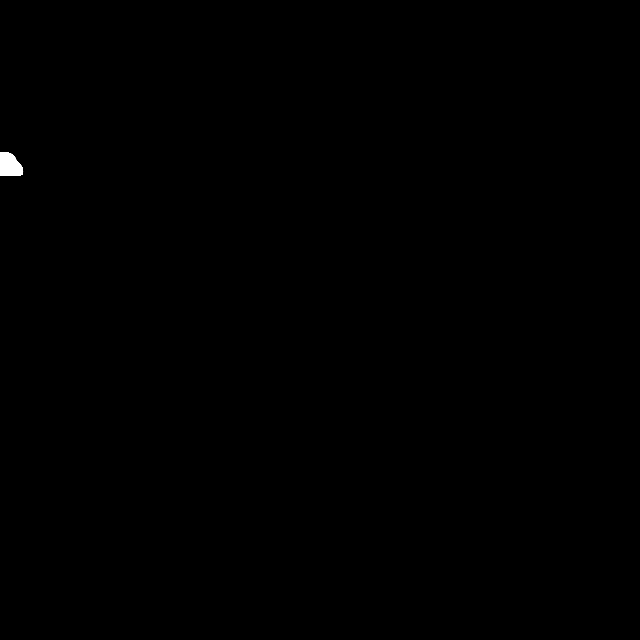

In [ ]:
upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
# upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)

print(upscaled_masks.shape)
Image.fromarray(upscaled_masks.cpu().numpy()[0,0] * 255).convert("RGB")

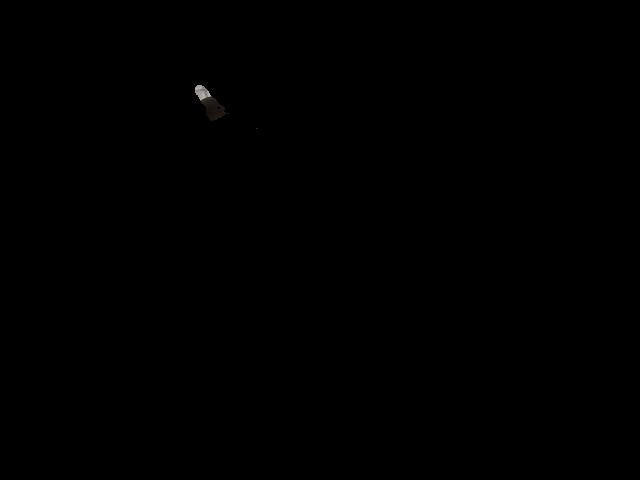

In [ ]:
# upscale low_res_masks to 1024x1024
high_res_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False).detach().cpu().numpy()[0,0]

thresholded = (high_res_masks > 0).astype(np.uint8)
Image.fromarray(img * thresholded[...,None]).convert("RGB")

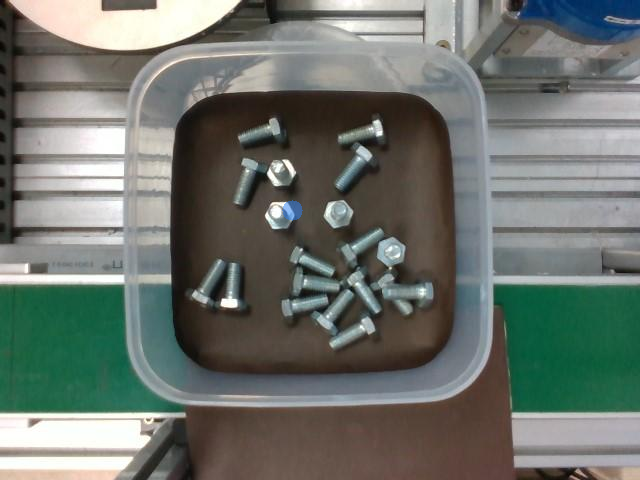

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)

# Predict on Test Set

# Segment Everything

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = predictor.model
# model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = list(valid_dataset.images.values())[0]
# img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.5,pred_iou_thresh=-0.6,points_per_side=64)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
iou_preds tensor(-0.5575, device='cuda:0')
iou_preds tensor(-0.5540, device='cuda:0')
iou_preds tensor(-0.5594, device='cuda:0')
iou_preds tensor(-0.5783, device='cuda:0')
iou_preds tensor(-0.6488, device='cuda:0')
iou_preds tensor(-0.6190, device='cuda:0')
iou_preds tensor(-0.6016, device='cuda:0')
iou_preds tensor(-0.5951, device='cuda:0')
iou_preds tensor(-0.5964, device='cuda:0')
iou_preds tensor(-0.5989, device='cuda:0')
iou_preds tensor(-0.6014, device='cuda:0')
iou_preds tensor(-0.6021, device='cuda:0')
iou_preds tensor(-0.5982, device='cuda:0')
iou_preds tensor(-0.5844, device='cuda:0')
iou_preds tensor(-0.5658, device='cuda:0')
iou_preds tensor(-0.5635, device='cuda:0')
iou_preds tensor(-0.5794, device='cuda:0')
iou_preds tensor(-0.6494, device='cuda:0')
iou_preds tensor(-0.6540, device='cuda:0')
iou_preds tensor(-0.6364, device='cuda:0')
iou_preds tensor(-0.6155, device='cuda:0')
iou_preds tensor(-0.6039, device='cuda:0')
iou_preds tensor(-0.

NotImplementedError: TODO: fix this

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

# Distance utils

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(train_dataset.images.keys()))

rand_img_dets = train_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances
    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map
empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))

# Progressive mask gen

In [ ]:
import supervision as sv

class LabellingSession:
    def __init__(self,img:np.ndarray):
        self.img = img
        self.sv_dataset = sv.DetectionDataset(
            classes=train_dataset.classes,
            images={
                "test":img
            },
            annotations={
                "test":sv.Detections.empty()
            }
        )
        self.torch_dataset = SamNextMaskDataset(self.sv_dataset,predictor,device)
        self.annotator = sv.MaskAnnotator()
    
    def update_detections(self,detections:sv.Detections):
        self.sv_dataset.annotations["test"] = detections

    def img_to_tensors(self):
        return self.torch_dataset[0]
    
    def show(self):
        return Image.fromarray(self.annotator.annotate(scene=self.img,detections=self.sv_dataset.annotations["test"]))
    
    @torch.no_grad()
    def get_next_mask(self):
        decoder_input, _, (input_size,original_size), img, (unresized_img,resized_img) = self.img_to_tensors()
        H,W,_ = img.shape

        new_input = {**decoder_input}

        if vit_lora:
            sam_embedding = image_encoder(resized_img)[0]
            new_input["image_embeddings"] = sam_embedding

        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]

            curr_embedding = new_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        assert len(iou_predictions.shape) == 1, f"IoU predictions shape is {iou_predictions.shape}"

        pred_idx = torch.argmax(iou_predictions)
        pred_mask = high_res_masks[pred_idx] > 0

        # new detection
        masks = pred_mask[None, :, :].cpu().numpy()
        class_id = 0
        new_dets = sv.Detections(
            xyxy=sv.Detections.mask_to_xyxy(masks),
            mask=masks,
            class_id=np.array([class_id]),
        )

        self.update_detections(new_dets)


In [ ]:
demo_img = cv2.imread("test.jpg")

session = LabellingSession(demo_img)

In [ ]:
session.get_next_mask()

session.show